# Blood Parasite Detection by Convolutional Neural Networks (CNNs)

### Problem Description

In this project we are trying to identify the presence of parasites in digital blood smears using Convolutional Neural Networks (CNN) to classify (binary classification) the images as showing signs of parasites or not. The data/contest/problem description is available at https://www.kaggle.com/competitions/parasitedetection-iiitb2019/, whereas a more detailed description of the data can be found at https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets/. The dataset has 20,465 images of various sizes for training. There are 1,587 test images..

## 0) Setup

### Import Required Libraries

In [1]:
# Import required (and probably some unused stragglers) libraries
import pandas as pd
import numpy as np
import pandas as pd
import sklearn
import os
import itertools
import shutil
import random
import glob
import warnings
import urllib.request
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras import initializers
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Input, Dropout, ReLU, CenterCrop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from visualkeras import layered_view
from keras.regularizers import l2
import keras_tuner as kt
from sklearn.metrics import confusion_matrix
import tensorflow.python.keras.backend as K

Here I simply display versioning of various packages. As you work through the book, you may find when researching some odd errors that it can be related to specific combinations of deprecated version packages, so these can be helpful references to have.

In [2]:
keras.__version__

'3.4.1'

In [3]:
tf.__version__

'2.17.0'

In [4]:
kt.__version__

'1.4.7'

Now let's bring in the raw data. One thing to note is that the training date is provided in separate directories for parasitized and uninfected blood samples. In the subsequent block we will combine these into a more practical data object. As shown here and alluded to in the introductory block, there are a total of 22,046 training images and 1,587 test images.

In [5]:
train_parasite_len = len(os.listdir('./parasitedetection-iiitb2019/Parasite/Parasite/train/Parasitized/'))

train_uninfected_len = len(os.listdir('./parasitedetection-iiitb2019/Parasite/Parasite/train/Uninfected/'))

test_dir_len = len(os.listdir('./parasitedetection-iiitb2019/Parasite/Parasite/test/'))

print("Parasitic Train Size: {}".format(train_parasite_len ))
print("Uninfected Train Size: {}".format(train_uninfected_len))
print("Total Train Size: {}".format(train_parasite_len + train_uninfected_len))
print("Test Size: {}".format(test_dir_len))

Parasitic Train Size: 11023
Uninfected Train Size: 11023
Total Train Size: 22046
Test Size: 1587


Here is where I combine the parasitized and uninfected blood samples into a single dataframe. It's not that I am actually modifying the directories, but the id column of the dataframe is really the full location of the files, thus accomodating the separate sub-directories.

In [ ]:
full_train_df = pd.DataFrame()

parasitic_imgs = os.listdir("./parasitedetection-iiitb2019/Parasite/Parasite/train/Parasitized/")
for img in parasitic_imgs:
    new_row = {"id": "./parasitedetection-iiitb2019/Parasite/Parasite/train/Parasitized/" + img, "label": 1}
    full_train_df = pd.concat([full_train_df, pd.DataFrame([new_row])], ignore_index=True)

parasitic_imgs = os.listdir("./parasitedetection-iiitb2019/Parasite/Parasite/train/Uninfected/")
for img in parasitic_imgs:
    new_row = {"id": "./parasitedetection-iiitb2019/Parasite/Parasite/train/Uninfected/" + img, "label": 0}
    full_train_df = pd.concat([full_train_df, pd.DataFrame([new_row])], ignore_index=True)

Now let's shuffle the dataframe (not super necessary, but it will be better when we take a peek at it here) and take a look at the first 10 entries, which show that we really do have a mix now of both binary labels.

In [7]:
full_train_df = full_train_df.sample(frac=1).reset_index(drop=True)
full_train_df.head(10)

,id,label
0,./parasitedetection-iiitb2019/Parasite/Parasit...,1
1,./parasitedetection-iiitb2019/Parasite/Parasit...,1
2,./parasitedetection-iiitb2019/Parasite/Parasit...,0
3,./parasitedetection-iiitb2019/Parasite/Parasit...,0
4,./parasitedetection-iiitb2019/Parasite/Parasit...,1
5,./parasitedetection-iiitb2019/Parasite/Parasit...,0
6,./parasitedetection-iiitb2019/Parasite/Parasit...,0
7,./parasitedetection-iiitb2019/Parasite/Parasit...,0
8,./parasitedetection-iiitb2019/Parasite/Parasit...,0
9,./parasitedetection-iiitb2019/Parasite/Parasit...,1


## 1) Exploratory Data Analysis (EDA)

#### Data Balance

The first thing we will do is take a look at the distribution of our data to assess its "balance." This is somewhat trivial, as since the dataset came in the separated sub-directories we worked with above, we already know that the data is perfectly balanced. This is further confirmed here in the piechart below. Accordingly, data balance/distribution should not be a major concern in our modelling decisions. Nevertheless, since we have a binary problem we will want to keep this split in mind and ensure that our model is performing meaningfully better than just a random guess.

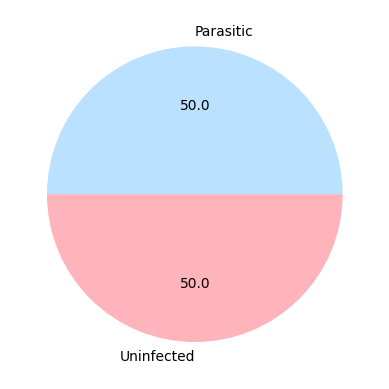

<Figure size 1600x1600 with 0 Axes>

In [8]:
plt.pie([train_parasite_len, train_uninfected_len], labels=['Parasitic', 'Uninfected'], autopct='%1.1f', colors=['#bae1ff','#ffb3ba'])
plt.figure(figsize=(16,16))
plt.show()

#### Data Visualization

Let's now take a look at 20 random samples from the training data. Recall that a 1 label indicates that at least one pixel in the center region shows signs of a tumor.

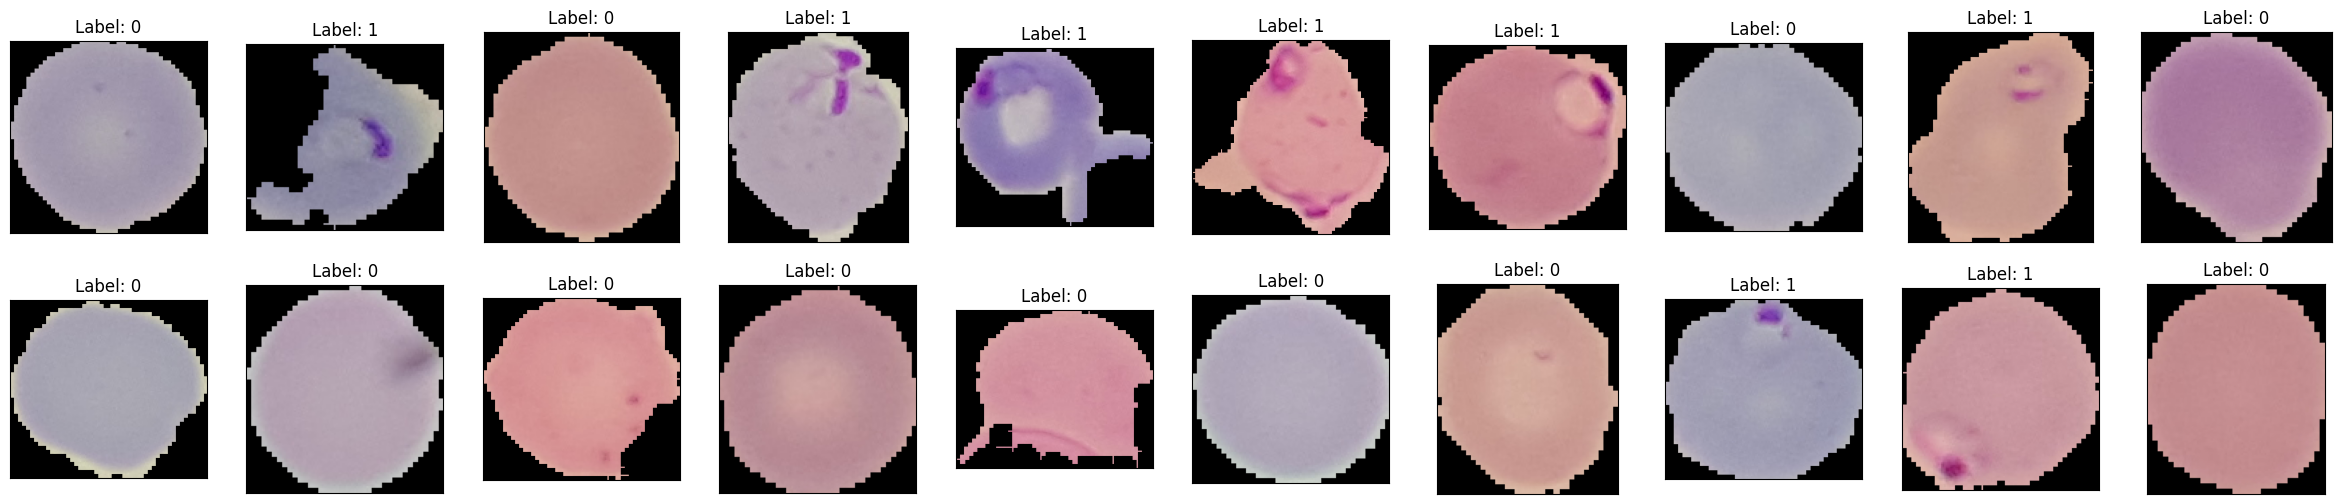

In [9]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = full_train_df.id
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(img)
    plt.imshow(im)
    lab = full_train_df.loc[full_train_df['id'] == img, 'label'].values[0]
    ax.set_title('Label: %s'%lab)

#### Image (Pixel) Dimensions

We are not specifically told in the dataset that images are all of some identical size. However, at least for the approach that we will take in this book, images will have to be adjusted to a consistent size throughout. Furthermore, it is typical practice to downsize images fed into a CNN. So here I take a look at what the average image size is, but also the min and max dimensions as well. Ideally, I would like to be able to downsize slightly from the average dimensionality, but without having to deviate significantly from the raw size for any given image. The results are ok - the average dimensions seem to be around 133x133, with possible extremes of 46x46, 46x364, 382x46, or 382x364. Accordingly, I am going to downsize all images to be squares of 96x96 pixels in all subsequent analysis.

In [10]:
img = Image.open(full_train_df.id[0]) 
  
# get initial width and height 
min_width = img.width 
max_width = img.width
min_height = img.height 
max_height = img.height
avg_width = 0
avg_height = 0

# iterate through everything
iter_count = 0
for im in full_train_df.id:
    img = Image.open(im)
    width = img.width 
    height = img.height 
    if (width < min_width):
        min_width = width
    if (width > max_width):
        max_width = width
    if (height < min_height):
        min_height = height
    if (height > max_height):
        max_height = height
    avg_width += width
    avg_height += height
    iter_count += 1

avg_width = avg_width / iter_count
avg_height = avg_height / iter_count

print("The average image height is: ", avg_height) 
print("The average image width is: ", avg_width)
print("The min image height is: ", min_height) 
print("The min image width is: ", min_width)
print("The max image height is: ", max_height) 
print("The max image width is: ", max_width)

The average image height is:  133.02095618252744
The average image width is:  132.51229247936135
The min image height is:  46
The min image width is:  46
The max image height is:  382
The max image width is:  364


### Data Cleaning/Preprocessing

I start here with a quick conversion of the labels to strings. This is just necessary in order to work with that flow_from_dataframe() method in Keras later.

In [11]:
# The label must be converted from int64 to string to work with the flow_from_dataframe function
full_train_df['label'] = full_train_df['label'].astype(str)
full_train_df.head()

,id,label
0,./parasitedetection-iiitb2019/Parasite/Parasit...,1
1,./parasitedetection-iiitb2019/Parasite/Parasit...,1
2,./parasitedetection-iiitb2019/Parasite/Parasit...,0
3,./parasitedetection-iiitb2019/Parasite/Parasit...,0
4,./parasitedetection-iiitb2019/Parasite/Parasit...,1


#### Image Normalization and Generator Initialization

Here I set up some functions that will help preprocess and normalize the data. The first function creates an ImageDataGenerator with standard-normalized values. I also set the horizontal and vertical flippings to true, since by all intuition those orientations should not be directly related to the outcome and may help the model generalize. Finally, I create the flow from dataframe, which importantly shifts us into grayscale in order to compress the third dimension of the original data. Basically I made the assumption that the RGB dimension did not matter in order to simplify my model. I know nothing about blood parasite-ology so this may be a terrible assumption, but nevertheless I'm just trying to streamline this whole thing.

In [12]:
def create_datagen(validation_split, preprocessing_function=None):
    return ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        validation_split=validation_split,
        samplewise_center=True,
        samplewise_std_normalization=True,
        horizontal_flip=True,
        vertical_flip=True)

def create_flow(datagen, directory, train_pairs, x_col, y_col, target_size, batch_size, class_mode, subset):
    return datagen.flow_from_dataframe(
        dataframe=train_pairs,
        directory=train_path,
        x_col=x_col, 
        y_col=y_col,
        target_size=target_size,
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode=class_mode,
        use_multiprocessing=True,
        subset=subset,
        shuffle=False
    )

Now let's run through the functions created above, effectively initializing our generator, and normalizing/preprocessing our images. Note that I also siphon off 40% of the data for validation here.

In [13]:
# Image preprocessing
target_size = (96, 96)
batch_size_train = 64

train_path = '.'

datagen = create_datagen(0.4)
trainor = create_flow(datagen, train_path, full_train_df, 'id', 'label', target_size, batch_size_train, 'binary', 'training')
validator = create_flow(datagen, train_path, full_train_df, 'id', 'label', target_size, batch_size_train, 'binary', 'validation')

Found 13228 validated image filenames belonging to 2 classes.
Found 8818 validated image filenames belonging to 2 classes.


Here let's take a quick peek at what some images look like after all of this preprocessing. The big thing to note here is the grayscaling of the color channels, as well as the lower pixelation as a result of the image downsizing (ON AVERAGE!!). Still, we see that the existence of parasites seems to come through clearly still, a great sign for the subsequent performance of the model. 

In [14]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

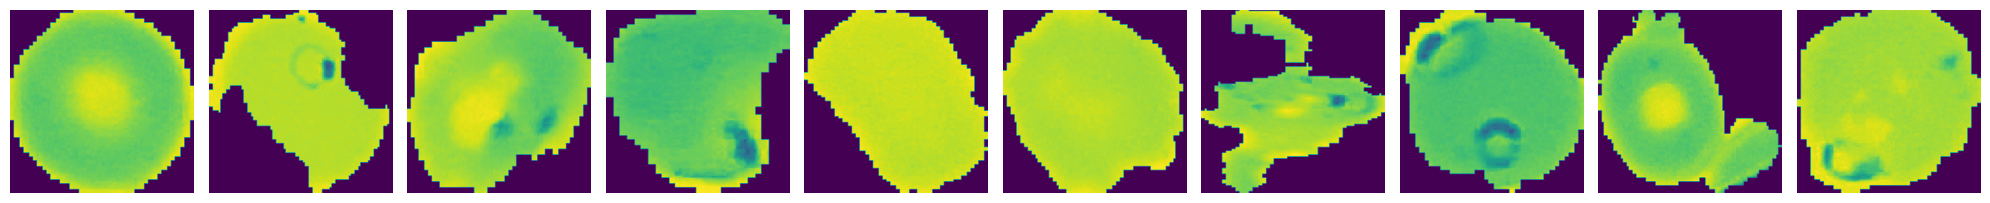

In [15]:
imgs, labels = next(trainor)
plotImages(imgs)

## 2) Model Building and Fitting

In [16]:
# Quick function to reinitialize weights that may come in handy for manual tuned re-reruns of the same model.
def reinitialize(model):
    sess = K.get_session()
    for layer in model_1.layers:
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.assign(layer.kernel_initializer(tf.shape(layer.kernel)))

Now we can start building and training an actual CNN. I start by building a Keras Sequential model below. For the sake of this exercise I had an eye to keeping the number of parameters low so that training times would be reasonable, so this is likely far from an ideal/optimal architecture. A final summary of the model is shown a few cells below. This particular architecture results in about 48,000 parameters (the vast majority of these come in the dense layers of the post-convolution neural network). The first convolution layer uses a larger kernel with no padding due to the fact that the blood smears (and roughly then the existence of the parasite, if any), seem to be centered in the images, so the loss of information at the edges could be justified. These filters are then pooled and normalized. A second convolution layer performs something similar but with a typically smaller kernel. From there, I flatten the result and build a fairly standard neural network with three hidden layers and finally sigmoid the result to get a classifier (could have easily used softmax here but since this is binary it achieves the same result).

In [17]:
model_1 = Sequential([
    Input(shape = (96, 96, 1)),

    # Convolution Layer 1
    Conv2D(filters=8, kernel_size=(5, 5), padding='valid', kernel_initializer=initializers.HeNormal()),
    ReLU(),
    MaxPool2D(pool_size=(3, 3), padding='same'),
    BatchNormalization(),

    # Convolution Layer 2
    Conv2D(filters=6, kernel_size=(3, 3), padding='same', kernel_initializer=initializers.HeNormal()),
    ReLU(),
    MaxPool2D(pool_size=(3, 3), padding='same'),
    BatchNormalization(),

    # Neural Network/Classifier Layer
    Flatten(),
    Dense(64),
    ReLU(),
    Dense(16),
    ReLU(),
    Dense(8),
    ReLU(),
    Dense(1, activation='sigmoid'),
])

In [18]:
# Compile and prepare model for training
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics = ['accuracy', 'precision', 'recall'])

In [19]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 92, 92, 8)           │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 92, 92, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 31, 31, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 31, 31, 6)           │             438 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 31, 31, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 11, 11, 6)           │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 726)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          46,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,415 (189.12 KB)

 Trainable params: 48,387 (189.01 KB)

 Non-trainable params: 28 (112.00 B)

In [20]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, start_from_epoch=5)

Here's just a quick function to help us plot performance metrics from the Keras training logs later.

In [21]:
def plot_metric(training_log, metric_name, title):
    plt.plot(training_log.history[metric_name])
    plt.plot(training_log.history['val_' + metric_name])
    plt.title('Model ' + metric_name)
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title(title)
    plt.show()

#### Fit the real training models

Now let's train the sequential model. We'll importantly look out for both training convergence but also validation results (possible overfitting). We will tune the model later to deal with these observations.

In [22]:
# Re-initialize the weights of the model
reinitialize(model_1)

# Fit
training_log = model_1.fit(x=trainor, 
                        validation_data=validator, 
                        epochs=25, 
                        verbose=1,
                        )

Epoch 1/25


C:\Program Files\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


207/207 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.6038 - loss: 0.6391 - precision: 0.6438 - recall: 0.4691 - val_accuracy: 0.7409 - val_loss: 0.5091 - val_precision: 0.6710 - val_recall: 0.9451
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.8036 - loss: 0.4249 - precision: 0.8041 - recall: 0.8055 - val_accuracy: 0.7862 - val_loss: 0.4473 - val_precision: 0.8993 - val_recall: 0.6445
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.8347 - loss: 0.3630 - precision: 0.8472 - recall: 0.8254 - val_accuracy: 0.7837 - val_loss: 0.4633 - val_precision: 0.7451 - val_recall: 0.8625
Epoch 4/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.8731 - loss: 0.2946 - precision: 0.8892 - recall: 0.8596 - val_accuracy: 0.8683 - val_loss: 0.3352 - val_precision: 0.8325 - val_recall: 0.9222
Epoch 5/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.9028 - loss: 0.2399 - precision: 0.9121 - recall: 0.8913 - val_accuracy: 0.7987 - val_loss: 0.4

Looking at the metric plots below, we are actually getting really great performance from this model already. The training results are converging to a very high accuracy, but even more important than that, the model seems to be generalizing very well to the validation data, which achieves similar results to the training data. Nevertheless, as the model chosen above was totally arbitrary, we will still do some hyperparameter tuning later.

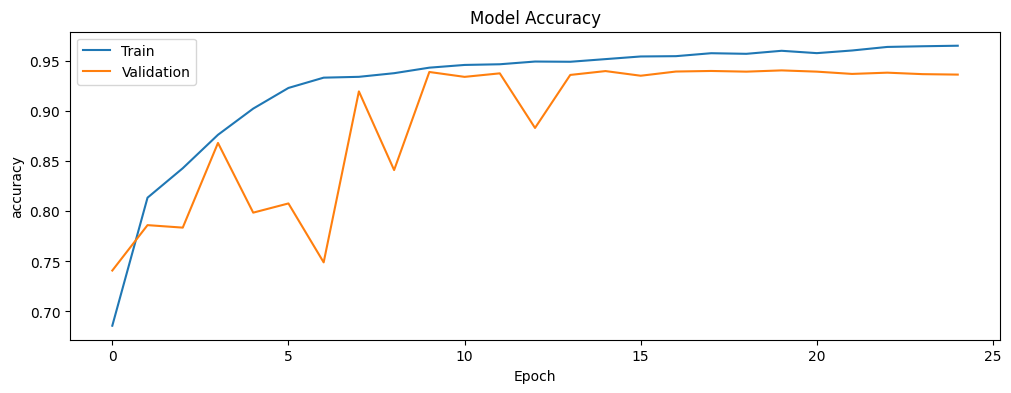

In [23]:
plt.figure(figsize=(12, 4))
plot_metric(training_log, 'accuracy', 'Model Accuracy')

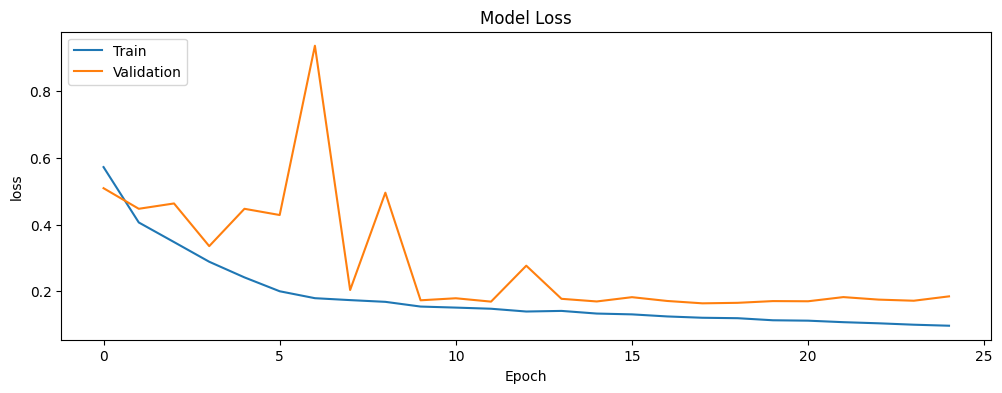

In [24]:
plt.figure(figsize=(12, 4))
plot_metric(training_log, 'loss', 'Model Loss')

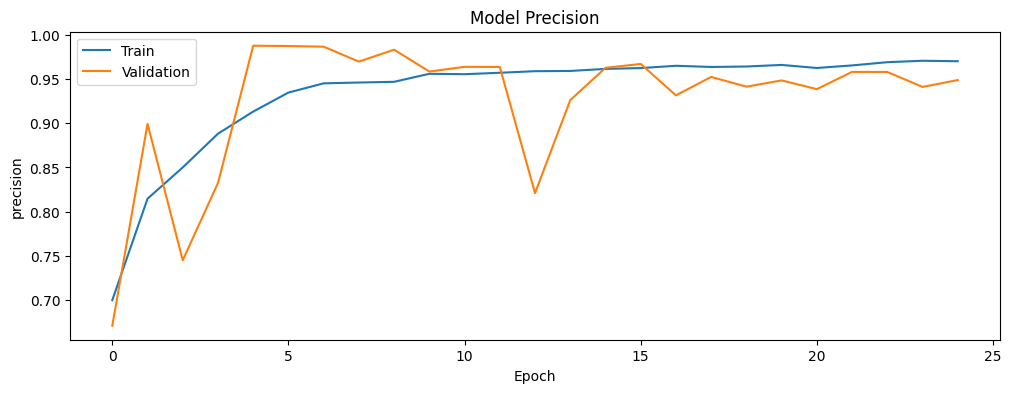

In [25]:
plt.figure(figsize=(12, 4))
plot_metric(training_log, 'precision', 'Model Precision')

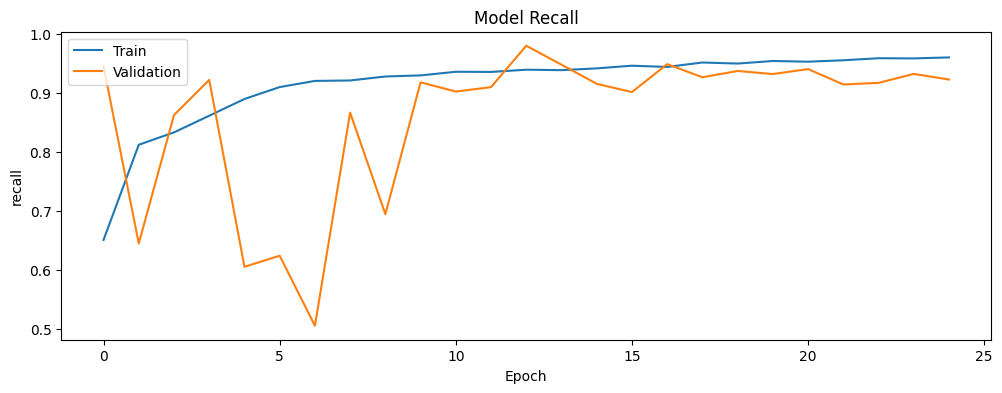

In [26]:
plt.figure(figsize=(12, 4))
plot_metric(training_log, 'recall', 'Model Recall')

## 3) Hyperparameter Tuning


As mentioned above, our model appears to perform very well, but all hyperparameters, while reasonable and somewhat typical, were chosen arbitrarily. With that in mind, now we'll tune some of the hyperparameters of the model using the Keras tuner, focusing on the validation loss. The overall architecture (i.e. number of convolution layers, number of dense layers, etc) of the model will be the same, and we'll search for things like optimal filter and kernel sizes. In addition, I'm going to add a kernel regularizer/penalty to the Dense layers (just as a note on the way these layer classes work - anything can be regularized, even the convolution layers, but since the overwhelming majority of parameters are in the dense layers, I focus the regularization there. I could have additionally used Dropout layers, but will refrain from that now and maybe play around with it at a later time).

In [27]:
def build_model(hp):
  model = Sequential([
        Input(shape = (96, 96, 1)),

        # Convolution Layer 1
        Conv2D(filters=hp.Int("conv_filters1", min_value=6, max_value=16, step=1), padding='valid', kernel_size=hp.Int("kernel_size1", 3, 7, step=2), kernel_initializer=initializers.HeNormal()),
        ReLU(),
        MaxPool2D(pool_size=(2, 2), padding='same'),
        BatchNormalization(),

        # Convolution Layer 2
        Conv2D(filters=hp.Int("conv_filters2", min_value=2, max_value=12, step=1), padding='same', kernel_size=hp.Int("kernel_size2", 3, 7, step=2), kernel_initializer=initializers.HeNormal()),
        ReLU(),
        MaxPool2D(pool_size=(2, 2), padding='same'),
        BatchNormalization(),

        # Neural Network/Classifier Layer
        Flatten(),
        Dense(hp.Int("dense_nodes1", min_value=32, max_value=128, step=8), kernel_regularizer=l2(0.001)),
        ReLU(),
        Dense(hp.Int("dense_nodes2", min_value=8, max_value=32, step=4), kernel_regularizer=l2(0.001)),
        ReLU(),
        Dense(hp.Int("dense_nodes3", min_value=4, max_value=16, step=2), kernel_regularizer=l2(0.001)),
        ReLU(),
        #Dropout(hp.Float("dropout1", min_value=0.15, max_value=0.6, step=0.025)),
        Dense(1, activation='sigmoid'),
    ])
  model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001, 0.00005, 0.00001])), loss='binary_crossentropy', metrics = ['accuracy'])
  return model

I'll use RandomSearch as the method here.

In [28]:
tuner = kt.RandomSearch(
    build_model,
    overwrite=True,
    objective='val_loss',
    max_trials=100)

Now the tuner kicks off.

In [29]:
tuner.search(trainor, epochs=20, validation_data=validator)

Trial 100 Complete [00h 07m 17s]
val_loss: 0.5242594480514526

Best val_loss So Far: 0.17837633192539215
Total elapsed time: 10h 45m 17s


We can grab the best model right out of the tuner using the get_best_models() method.

In [30]:
best_model = tuner.get_best_models()[0]

C:\Program Files\Python39\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Let's take a look at the summary of the optimized (not really probably, I did a rather small number of trials and epochs here to get results back faster) model. The main takeaways are that it is applying more filters across both convolutional layers. The dense layers have less nodes in total, however due to the beefing up of the convolutional layers, this model ends up having over 150,000 parameters, or more than 100,000 more parameters than our original model.

In [31]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 90, 90, 9)           │             450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 90, 90, 9)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 45, 45, 9)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 45, 45, 9)           │              36 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 9)           │           3,978 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 45, 45, 9)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 9)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 23, 23, 9)           │              36 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4761)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         152,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │             204 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              13 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,629 (615.74 KB)

 Trainable params: 157,593 (615.60 KB)

 Non-trainable params: 36 (144.00 B)

#### Tuned Model Clone and Results Analysis

Here I just recreate the tuned model so that I can train it and analyze the accuracy and loss metrics.

In [32]:
best_model_clone = best_model

In [34]:
# Re-initialize the weights of the model
reinitialize(best_model_clone)

# Fit
best_log = best_model_clone.fit(x=trainor, 
                        validation_data=validator, 
                        epochs=50, 
                        verbose=1,
                        )

Epoch 1/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.9784 - loss: 0.1057 - val_accuracy: 0.9439 - val_loss: 0.2277
Epoch 2/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.9790 - loss: 0.1044 - val_accuracy: 0.9466 - val_loss: 0.2431
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.9737 - loss: 0.1213 - val_accuracy: 0.9475 - val_loss: 0.2222
Epoch 4/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.9757 - loss: 0.1089 - val_accuracy: 0.9473 - val_loss: 0.2364
Epoch 5/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.9805 - loss: 0.1018 - val_accuracy: 0.9375 - val_loss: 0.2331
Epoch 6/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.9803 - loss: 0.1060 - val_accuracy: 0.9434 - val_loss: 0.2323
Epoch 7/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.9762 - loss: 0.1081 - val_accuracy: 0.9413 - val_loss: 0.2368
Epoch 8/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.9763 - loss: 0.

Finally here I plot the accuracy and loss metrics of the tuned model. As expected the model performs very well on the basis of validation accuracy and loss. There is a small delta to the training results, as expected, however all signs point to us being abel to say the the model generalizes well to new data.

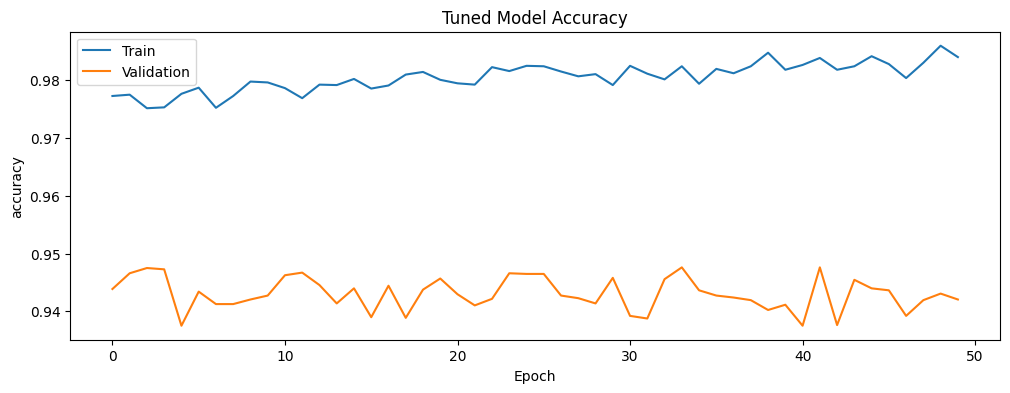

In [35]:
plt.figure(figsize=(12, 4))
plot_metric(best_log, 'accuracy', 'Tuned Model Accuracy')

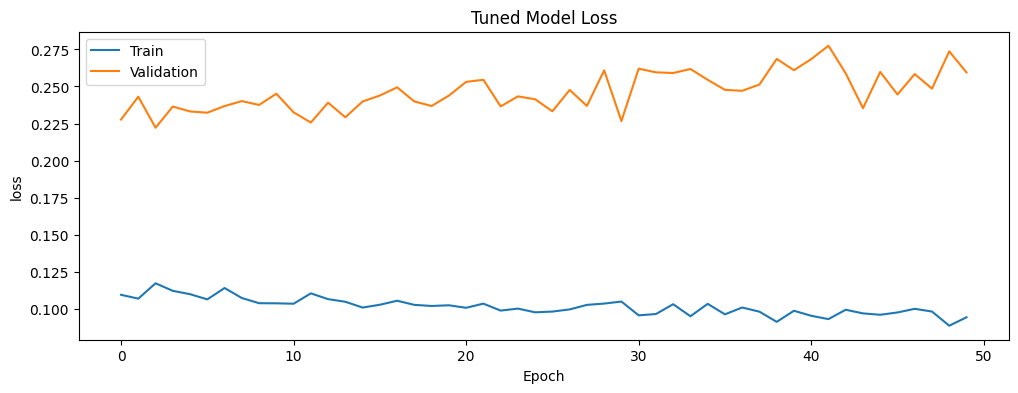

In [36]:
plt.figure(figsize=(12, 4))
plot_metric(best_log, 'loss', 'Tuned Model Loss')

## 4) Testing/Predictions

Now I simply take the best model from training and use it for prediction on the testing set. This is a bit of a meaningless step - I won't actually be submitting these results to the original Kaggle competition. But the code here can be a good reference for how you would generate lables off of the test images.

In [140]:
test_dir = './parasitedetection-iiitb2019/Parasite/Parasite/test/'

test_files = os.listdir(test_dir)
test_dataframe = pd.DataFrame(test_files, columns=['id'])

test_datagen = create_datagen(None) # Since testing, NO validation split

def create_test_flow(datagen, dataframe, directory, x_col, target_size, batch_size):
    return datagen.flow_from_dataframe(
         dataframe=test_dataframe,
         directory=directory,
         x_col=x_col, 
         y_col=None,
         target_size=target_size,
         color_mode='grayscale',
         batch_size=batch_size,
         class_mode=None,
         use_multiprocessing=True
     )

testor = create_test_flow(test_datagen, test_dataframe, test_dir, 'id', target_size, batch_size_train)

Found 57458 validated image filenames.


In [141]:
predictions = best_model.predict(testor)
predictions = np.transpose(predictions)[0]
print(f"Number of predictions: {len(predictions)}")
print(f"Number of test samples: {len(test_dataframe)}")
binary_predictions = (predictions >= 0.5).astype(int).flatten() # convert the sigmoid 0-1 to either 0 or 1
print(len(binary_predictions))
submission_dataframe = pd.DataFrame()
submission_dataframe['id'] = test_dataframe['id'].apply(lambda x: x.split('.')[0]) # remove .tif from the id
submission_dataframe['label'] = binary_predictions
submission_dataframe.to_csv('submission.csv', index=False)

225/225 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step
Number of predictions: 57458
Number of test samples: 57458
57458
